# Simulating on NVIDIA Graphics Card with CUDA

In [1]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS_Ocean/"

In [2]:
include(CODE_ROOT * "mode_init/MPAS_Ocean.jl")

include(CODE_ROOT * "mode_forward/time_steppers.jl")

include(CODE_ROOT * "visualization.jl")

vertexHeatMapMesh (generic function with 1 method)

In [3]:
import CUDA

In [4]:
CUDA.memory_status()

Effective GPU memory usage: 6.14% (498.250 MiB/7.921 GiB)
CUDA allocator usage: 0 bytes
Memory pool usage: 0 bytes (0 bytes allocated, 0 bytes cached)


In [5]:
const MAX_THREADS_PER_BLOCK = CUDA.attribute(
        CUDA.CuDevice(0), CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK,
)

1024

# Load Mesh From File

In [6]:
mpasOcean = MPAS_Ocean(false, CODE_ROOT * "MPAS_O_Shallow_Water/Mesh+Initial_Condition+Registry_Files/Periodic",
                "base_mesh.nc", "mesh.nc", periodicity="Periodic"
)
typeof(mpasOcean)

MPAS_Ocean

# Define Initial Condition

In [7]:
function gaussianInit!(mpasOcean; sx=1/3, sy=1/3, mx=1/2, my=1/2)
    sigmax = mpasOcean.lX*sx
    sigmay = mpasOcean.lY*sy
    
    mux = mpasOcean.lX*mx
    muy = mpasOcean.lY*my
    
    for iCell in 1:mpasOcean.nCells
        mpasOcean.sshCurrent[iCell] = exp( - (mpasOcean.xCell[iCell] - mux)^2 / sigmax^2 - (mpasOcean.yCell[iCell] - muy)^2 / sigmay^2 )
    end
    
    mpasOcean.normalVelocityCurrent .= 0
    
    return nothing
end

gaussianInit! (generic function with 1 method)

In [8]:
function planeWaveInit!(mpasOcean; rkx = 1, rky = 1)
    kx = rkx * 2 * pi / mpasOcean.lX
    ky = rky * 2 * pi / mpasOcean.lY
    
    for iCell in 1:mpasOcean.nCells
        mpasOcean.sshCurrent[iCell] = cos( kx * mpasOcean.xCell[iCell] + ky * mpasOcean.yCell[iCell] )
    end
    
    mpasOcean.normalVelocityCurrent .= 0
    
    mpasOcean.sshTendency[:] .= mpasOcean.sshCurrent[:]
    mpasOcean.normalVelocityTendency[:] .= mpasOcean.normalVelocityCurrent[:]
    
    return nothing
end

planeWaveInit! (generic function with 1 method)

In [15]:
moveArrays!(mpasOcean, Array)

gaussianInit!(mpasOcean) # could also do gaussianInit!

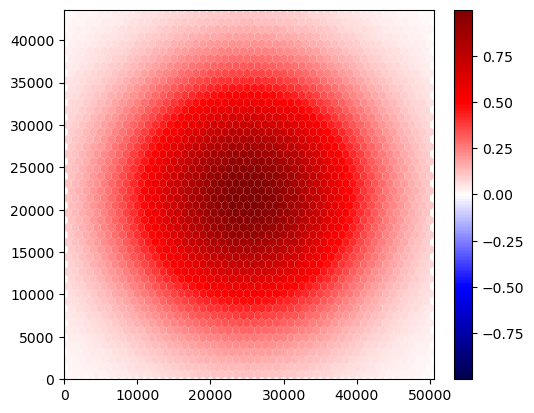

In [16]:
fig, ax, cbar, col = heatMapMesh(mpasOcean, mpasOcean.sshCurrent)
display(fig)

# Simulate Wave on GPU

In [17]:
# simulate and record nFrames snapshots of the SSH
nFrames = 30

sshOverTime = zeros(nFrames, mpasOcean.nCells)

moveArrays!(mpasOcean, CUDA.CuArray)

for i in 1:nFrames
    for j in 1:10
        forward_backward_step_cuda!(mpasOcean)
    end
    sshOverTime[i,:] = mpasOcean.sshCurrent[:]
end

## Animate Simulation

In [18]:
using PyCall, PyPlot

animation = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")

PyObject <module 'IPython.display' from '/home/rrs/anaconda3/envs/MPAS_Ocean/lib/python3.8/site-packages/IPython/display.py'>

In [19]:
# move it back to CPU for animation
moveArrays!(mpasOcean, Array)

cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(mpasOcean, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f7474f9dfa0>

In [20]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>